In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())   
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9357 - acc: 0.3945
Epoch 00001: val_loss improved from inf to 1.76198, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_6_conv_checkpoint/001-1.7620.hdf5
36805/36805 [==============================] - 177s 5ms/sample - loss: 1.9356 - acc: 0.3945 - val_loss: 1.7620 - val_acc: 0.4440
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3355 - acc: 0.5843
Epoch 00002: val_loss improved from 1.76198 to 1.75592, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_6_conv_checkpoint/002-1.7559.hdf5
36805/36805 [==============================] - 166s 5ms/sample - loss: 1.3356 - acc: 0.5844 - val_loss: 1.7559 - val_acc: 0.4659
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0913 - acc: 0.6680
Epoch 00003: val_loss improve

36800/36805 [============================>.] - ETA: 0s - loss: 0.2500 - acc: 0.9289
Epoch 00027: val_loss did not improve from 1.14300
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.2501 - acc: 0.9288 - val_loss: 2.0218 - val_acc: 0.6124
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2475 - acc: 0.9270
Epoch 00028: val_loss did not improve from 1.14300
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.2475 - acc: 0.9270 - val_loss: 2.2728 - val_acc: 0.5737
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9311
Epoch 00029: val_loss did not improve from 1.14300
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.2328 - acc: 0.9312 - val_loss: 2.1030 - val_acc: 0.5795
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2172 - acc: 0.9380
Epoch 00030: val_loss did not improve from 1.14300
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9730
Epoch 00056: val_loss did not improve from 0.80120
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0949 - acc: 0.9729 - val_loss: 0.8052 - val_acc: 0.8064
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9743
Epoch 00057: val_loss did not improve from 0.80120
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0897 - acc: 0.9743 - val_loss: 1.4112 - val_acc: 0.7170
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0850 - acc: 0.9759
Epoch 00058: val_loss did not improve from 0.80120
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0851 - acc: 0.9758 - val_loss: 1.7798 - val_acc: 0.6804
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9709
Epoch 00059: val_loss did not improve from 0.80120
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9869
Epoch 00085: val_loss did not improve from 0.79977
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0472 - acc: 0.9869 - val_loss: 1.0232 - val_acc: 0.7894
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9835
Epoch 00086: val_loss did not improve from 0.79977
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0559 - acc: 0.9835 - val_loss: 1.4152 - val_acc: 0.7372
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9859
Epoch 00087: val_loss did not improve from 0.79977
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0513 - acc: 0.9859 - val_loss: 1.2005 - val_acc: 0.7654
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9825
Epoch 00088: val_loss did not improve from 0.79977
36805/36805 [=====================

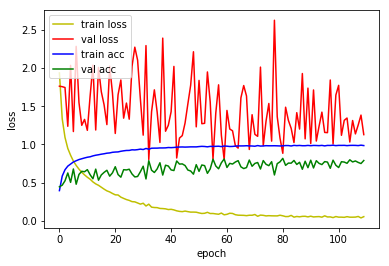

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.9171 - acc: 0.7780
Loss: 0.9171340922824072 Accuracy: 0.77798545

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0179 - acc: 0.3688
Epoch 00001: val_loss improved from inf to 1.73944, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_7_conv_checkpoint/001-1.7394.hdf5
36805/36805 [==============================] - 188s 5ms/sample - loss: 2.0179 - acc: 0.3688 - val_loss: 1.7394 - val_acc: 0.4559
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3865 - acc: 0.5681
Epoch 00002: val_loss did not improve from 1.73944
36805/36805 [==============================] - 169s 5ms/sample - loss: 1.3864 - acc: 0.5682 - val_loss: 1.8575 - val_acc: 0.4754
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1295 - acc: 0.6554
Epoch 00003: val_loss improved from 1.73944 to 1.50347, s

36805/36805 [==============================] - 169s 5ms/sample - loss: 0.2298 - acc: 0.9317 - val_loss: 0.5366 - val_acc: 0.8442
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2226 - acc: 0.9349
Epoch 00027: val_loss did not improve from 0.53661
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.2229 - acc: 0.9349 - val_loss: 0.8532 - val_acc: 0.7680
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2268 - acc: 0.9333
Epoch 00028: val_loss did not improve from 0.53661
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.2269 - acc: 0.9333 - val_loss: 0.7090 - val_acc: 0.8195
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2068 - acc: 0.9400
Epoch 00029: val_loss did not improve from 0.53661
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.2068 - acc: 0.9400 - val_loss: 1.8418 - val_acc: 0.6569
Epoch 30/500
36800/36805 [==============

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9735
Epoch 00055: val_loss did not improve from 0.41095
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0899 - acc: 0.9735 - val_loss: 0.6598 - val_acc: 0.8456
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9756
Epoch 00056: val_loss did not improve from 0.41095
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0823 - acc: 0.9755 - val_loss: 0.9050 - val_acc: 0.7929
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0771 - acc: 0.9769
Epoch 00057: val_loss did not improve from 0.41095
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0772 - acc: 0.9769 - val_loss: 0.8985 - val_acc: 0.8137
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0829 - acc: 0.9760
Epoch 00058: val_loss did not improve from 0.41095
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9872
Epoch 00084: val_loss did not improve from 0.41070
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0458 - acc: 0.9872 - val_loss: 0.4117 - val_acc: 0.9043
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9862
Epoch 00085: val_loss did not improve from 0.41070
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0489 - acc: 0.9862 - val_loss: 0.5507 - val_acc: 0.8677
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9838
Epoch 00086: val_loss did not improve from 0.41070
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0534 - acc: 0.9838 - val_loss: 0.5328 - val_acc: 0.8835
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9878
Epoch 00087: val_loss did not improve from 0.41070
36805/36805 [=====================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9874
Epoch 00113: val_loss did not improve from 0.40556
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0449 - acc: 0.9874 - val_loss: 0.4819 - val_acc: 0.9001
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9887
Epoch 00114: val_loss did not improve from 0.40556
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0391 - acc: 0.9887 - val_loss: 0.6529 - val_acc: 0.8567
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9901
Epoch 00115: val_loss improved from 0.40556 to 0.33947, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_7_conv_checkpoint/115-0.3395.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0374 - acc: 0.9901 - val_loss: 0.3395 - val_acc: 0.9222
Epoch 116/500
36800/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9958
Epoch 00142: val_loss did not improve from 0.33947
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0173 - acc: 0.9958 - val_loss: 0.3487 - val_acc: 0.9243
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9959
Epoch 00143: val_loss did not improve from 0.33947
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0176 - acc: 0.9959 - val_loss: 0.5943 - val_acc: 0.8705
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9899
Epoch 00144: val_loss did not improve from 0.33947
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0338 - acc: 0.9899 - val_loss: 0.9386 - val_acc: 0.8148
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9864
Epoch 00145: val_loss did not improve from 0.33947
36805/36805 [==================

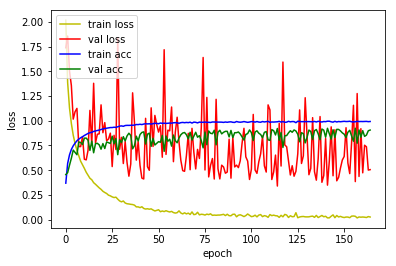

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4533 - acc: 0.9001
Loss: 0.45326784061246694 Accuracy: 0.90010387

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9961 - acc: 0.3804
Epoch 00001: val_loss improved from inf to 1.65901, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_8_conv_checkpoint/001-1.6590.hdf5
36805/36805 [==============================] - 199s 5ms/sample - loss: 1.9962 - acc: 0.3804 - val_loss: 1.6590 - val_acc: 0.4752
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3224 - acc: 0.5980
Epoch 00002: val_loss improved from 1.65901 to 1.33849, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_8_conv_checkpoint/002-1.3385.hdf5
36805/36805 [==============================] - 171s 5ms/sample - loss: 1.3223 - acc: 0.5980 - val_loss: 1.3385 - val_acc: 0.5821
Epoch 3/500
36800/36805 [============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - acc: 0.9573
Epoch 00026: val_loss did not improve from 0.24825
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.1448 - acc: 0.9573 - val_loss: 0.6452 - val_acc: 0.8174
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1349 - acc: 0.9599
Epoch 00027: val_loss did not improve from 0.24825
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1349 - acc: 0.9599 - val_loss: 0.2969 - val_acc: 0.9201
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1231 - acc: 0.9639
Epoch 00028: val_loss improved from 0.24825 to 0.23164, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_8_conv_checkpoint/028-0.2316.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.1231 - acc: 0.9639 - val_loss: 0.2316 - val_acc: 0.9341
Epoch 29/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9891
Epoch 00055: val_loss did not improve from 0.23164
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0393 - acc: 0.9891 - val_loss: 0.3688 - val_acc: 0.9099
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9860
Epoch 00056: val_loss did not improve from 0.23164
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0468 - acc: 0.9860 - val_loss: 0.7291 - val_acc: 0.8209
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9889
Epoch 00057: val_loss did not improve from 0.23164
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0399 - acc: 0.9889 - val_loss: 0.2363 - val_acc: 0.9397
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9892
Epoch 00058: val_loss did not improve from 0.23164
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9938
Epoch 00084: val_loss did not improve from 0.20926
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0212 - acc: 0.9938 - val_loss: 0.3485 - val_acc: 0.9168
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9926
Epoch 00085: val_loss did not improve from 0.20926
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0240 - acc: 0.9926 - val_loss: 0.3112 - val_acc: 0.9299
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9915
Epoch 00086: val_loss did not improve from 0.20926
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0281 - acc: 0.9915 - val_loss: 0.2516 - val_acc: 0.9373
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9940
Epoch 00087: val_loss did not improve from 0.20926
36805/36805 [========

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9963
Epoch 00114: val_loss did not improve from 0.20926
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0133 - acc: 0.9963 - val_loss: 0.2775 - val_acc: 0.9369
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9943
Epoch 00115: val_loss did not improve from 0.20926
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0214 - acc: 0.9943 - val_loss: 0.2133 - val_acc: 0.9497
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9933
Epoch 00116: val_loss did not improve from 0.20926
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0207 - acc: 0.9933 - val_loss: 0.3233 - val_acc: 0.9238
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9958
Epoch 00117: val_loss did not improve from 0.20926
36805/36805 [====

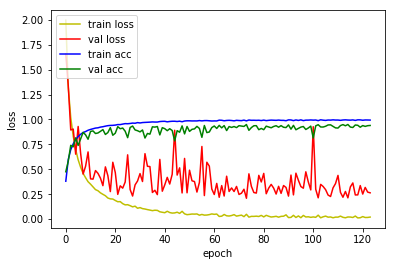

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2758 - acc: 0.9304
Loss: 0.2758367461687184 Accuracy: 0.93042576

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7369 - acc: 0.4610
Epoch 00001: val_loss improved from inf to 1.30898, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_9_conv_checkpoint/001-1.3090.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 1.7369 - acc: 0.4610 - val_loss: 1.3090 - val_acc: 0.6047
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9631 - acc: 0.7071
Epoch 00002: val_loss improved from 1.30898 to 0.93975, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_9_conv_checkpoint/002-0.9398.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.9631 - acc: 0.7071 - val_loss: 0.9398 - val_acc: 0.7072
Epoch 3/500
36800/36805 [=============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9844
Epoch 00026: val_loss did not improve from 0.19483
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0543 - acc: 0.9844 - val_loss: 0.2248 - val_acc: 0.9369
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9826
Epoch 00027: val_loss did not improve from 0.19483
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0599 - acc: 0.9826 - val_loss: 0.2042 - val_acc: 0.9443
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0528 - acc: 0.9846
Epoch 00028: val_loss did not improve from 0.19483
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0528 - acc: 0.9846 - val_loss: 0.1958 - val_acc: 0.9446
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9849
Epoch 00029: val_loss did not improve from 0.19483
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9907
Epoch 00055: val_loss did not improve from 0.17379
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0312 - acc: 0.9907 - val_loss: 0.2099 - val_acc: 0.9483
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9955
Epoch 00056: val_loss did not improve from 0.17379
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0163 - acc: 0.9955 - val_loss: 0.1912 - val_acc: 0.9539
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9964
Epoch 00057: val_loss did not improve from 0.17379
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0124 - acc: 0.9964 - val_loss: 0.2311 - val_acc: 0.9439
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9948
Epoch 00058: val_loss did not improve from 0.17379
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9960
Epoch 00084: val_loss did not improve from 0.17024
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0145 - acc: 0.9960 - val_loss: 0.2615 - val_acc: 0.9427
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9962
Epoch 00085: val_loss did not improve from 0.17024
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0133 - acc: 0.9962 - val_loss: 0.1935 - val_acc: 0.9581
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9935
Epoch 00086: val_loss did not improve from 0.17024
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0219 - acc: 0.9935 - val_loss: 0.1839 - val_acc: 0.9613
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9986
Epoch 00087: val_loss did not improve from 0.17024
36805/36805 [=====================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9950
Epoch 00113: val_loss did not improve from 0.16320
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0168 - acc: 0.9950 - val_loss: 0.1931 - val_acc: 0.9597
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9989
Epoch 00114: val_loss did not improve from 0.16320
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0040 - acc: 0.9989 - val_loss: 0.2044 - val_acc: 0.9581
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9989
Epoch 00115: val_loss did not improve from 0.16320
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0049 - acc: 0.9989 - val_loss: 0.2863 - val_acc: 0.9355
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9945
Epoch 00116: val_loss did not improve from 0.16320
36805/36805 [====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9985
Epoch 00142: val_loss did not improve from 0.16287
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0055 - acc: 0.9985 - val_loss: 0.2579 - val_acc: 0.9408
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9964
Epoch 00143: val_loss did not improve from 0.16287
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0112 - acc: 0.9964 - val_loss: 0.2365 - val_acc: 0.9502
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9976
Epoch 00144: val_loss did not improve from 0.16287
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0076 - acc: 0.9976 - val_loss: 0.1948 - val_acc: 0.9599
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9988
Epoch 00145: val_loss did not improve from 0.16287
36805/36805 [==================


1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_9_conv Model


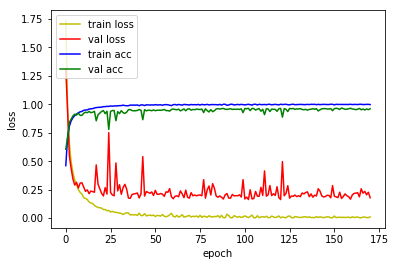

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2248 - acc: 0.9489
Loss: 0.22481658297899418 Accuracy: 0.94890964



In [10]:
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN'

for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.9698 - acc: 0.6565
Loss: 1.9697624433325336 Accuracy: 0.65649015

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (A

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.9171 - acc: 0.7780
Loss: 0.9171340922824072 Accuracy: 0.77798545

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_102 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_102 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_103 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_103 (

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2758 - acc: 0.9304
Loss: 0.2758367461687184 Accuracy: 0.93042576

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2248 - acc: 0.9489
Loss: 0.22481658297899418 Accuracy: 0.94890964


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)

4815/4815 [==============================] - 9s 2ms/sample - loss: 2.5005 - acc: 0.6393
Loss: 2.5005284367320693 Accuracy: 0.63925236

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (A

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.3571 - acc: 0.7524
Loss: 1.3571312575325416 Accuracy: 0.7524403

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_102 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_102 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_103 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_103 (A

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.3322 - acc: 0.9250
Loss: 0.33215706567526604 Accuracy: 0.92502594

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2706 - acc: 0.9443
Loss: 0.2705540340819308 Accuracy: 0.9443406
